# Q1. Text Classification with BERT & from-scratch Attention
---

## Preprocessing

### Analysis of `train.csv` to decide appropriate preprocessing
1. Looks like data scraped from some job-posting portal.
2. Most entries include name, age, address, phone no. and email of the applicant. This is not relevant to the label of text, hence must be removed. However, this data doesn't follow a strict format across samples.
3. Only first 5738 entries seem to be real-world data. Remaining ~7000 entries are most likely synthetic data as the applicant details are the same (eg. name is Jessica Claire).
4. Data is already lemmatized. Stop-words, punctuation, casing etc. has already been removed.

### Step 1: Remove common words
1. **Number Removal**: All numeric values are removed as they're likely not useful for classification and often part of personal information.
2. **Common words removal**: An efficient word counter of all words in the training data is created. Words which appear in `> N * commonWordsThreshold` of the entries are removed, since they most likely don't differentiate the entries. Eg. ***experience, summary, contact, jessica***.

In [1]:
import pandas as pd
import re
from collections import Counter

# Load the dataset
sample_df = pd.read_csv('../T_Q1/train.csv')
N = 13389

# Remove numbers
sample_df['cleaned_text'] = sample_df['Text'].apply(lambda x: re.sub(r'\d+', '', x))

# Efficiently count number of occurences of each word
word_counter = Counter()
for text in sample_df['cleaned_text']:
    for word in set(text.split()):
        if word:
            word_counter[word] += 1

# Remove words with frequency greater than the threshold
commonWordsThreshold = 0.2
frequent_words = {word for word, count in word_counter.items() if count >= int(N * commonWordsThreshold)}
print(f"Total unique words across all entries: {len(word_counter)}")
print(f"Words appearing in {commonWordsThreshold*100:.0f}% of data: {len(frequent_words)}")

def remove_frequent_words(text, frequent_words):
    filtered_words = [word for word in text.split() if word not in frequent_words]
    return ' '.join(filtered_words)
sample_df['final_text'] = sample_df['cleaned_text'].apply(lambda text: remove_frequent_words(text, frequent_words))

Total unique words across all entries: 110401
Words appearing in 20% of data: 214


1. Calculate reduction in average word count per entry after removing common words.  
2. This helps in analyzing impact of data cleaning and choosing appropriate threshold.  
3. The cleaned data is stored in `train_v2.csv`

In [2]:
sample_df['original_word_count'] = sample_df['cleaned_text'].apply(lambda x: len(x.split()))
sample_df['final_word_count'] = sample_df['final_text'].apply(lambda x: len(x.split()))

original_avg_words = sample_df['original_word_count'].mean()
final_avg_words = sample_df['final_word_count'].mean()
avg_word_reduction = original_avg_words - final_avg_words
percent_avg_word_reduction = (avg_word_reduction / original_avg_words) * 100

print(f"Original average word count: {original_avg_words:.2f} words")
print(f"Final average word count: {final_avg_words:.2f} words")
print(f"Reduction in average word count: {avg_word_reduction:.2f} words ({percent_avg_word_reduction:.2f}%)")

output_df = sample_df[['Category', 'final_text']]
output_df.columns = ['Category', 'Text']
output_df.to_csv('../T_Q1/train_v2.csv', index=False)

Original average word count: 458.83 words
Final average word count: 306.99 words
Reduction in average word count: 151.83 words (33.09%)


Following is the category-wise distribution of dataset, used to predict intitial `commonWordsThreshold` value.
<div>
    <img src="media/categoryDescription.png" style="max-width: auto; height: 400px;">
    <img src="media/categoryHistogram.png" style="max-width: auto; height: 400px;">
</div>

The following graphs show the effect of the data cleaning process above for different thresholds.  
The final choice of threshold was 20%.
<div>
    <img src="media/avgWordCountReduction.png" style="max-width: 45%; height: auto;">
    <img src="media/noOfFrequentWords.png" style="max-width: 45%; height: auto;">
</div>

---
##### The final `commonWordsThreshold` was chosen after training the final model with different thresholds and analyzing effect on performance.
---

### Step 2: Removing personal information
The first 5738 entries have personal information while the rest don't (all Jessica Claire related information was removed in the previous cleaning step). Hence, only these are considered for this step.

1. The first two words for most entries' is the applicant's name. This is removed.
2. In the next 8 words, any word ending with **com** or **net** is removed as they are likely emails.

**The neccesity of this step is not so much the model accuracy, as it is about privacy and safety.**

In [3]:
df = pd.read_csv('../T_Q1/train_v2.csv')

def remove_personal_info(row_idx, text):
    words = text.split()
    original_word_count = len(words)
    
    # Process only first 5738 entries as mentioned in the cell above
    if row_idx < 5738:
        if len(words) >= 2:
            words = words[2:]
        
        for i in range(min(8, len(words))):
            if words[i].endswith('com') or words[i].endswith('net'):
                words[i] = ''
    
    words = [w for w in words if w]
    cleaned_text = ' '.join(words)
    final_word_count = len(words)
    return cleaned_text, original_word_count - final_word_count

# Apply the function to each row
results = [remove_personal_info(i, text) for i, text in enumerate(df['Text'])]

# Calculate statistics
df['cleaned_text'] = [r[0] for r in results]
word_reductions = [r[1] for r in results]
total_original_words = sum(len(text.split()) for text in df['Text'])
total_removed_words = sum(word_reductions)
percentage_reduction = (total_removed_words / total_original_words) * 100

print(f"Percentage reduction: {percentage_reduction:.2f}%")

output_df = df[['Category', 'cleaned_text']]
output_df.columns = ['Category', 'Text']

output_df.to_csv('../T_Q1/train_v3.csv', index=False)


Percentage reduction: 0.38%


The following graph shows the word count of entries as a histogram. BERT transformer has a token limit of 512 tokens. Hence, only around 500 words can be stored.

Word count statistics:
  Minimum: 2
  Maximum: 4538
  Mean: 305.83
  Median: 256.0
  Standard deviation: 219.58


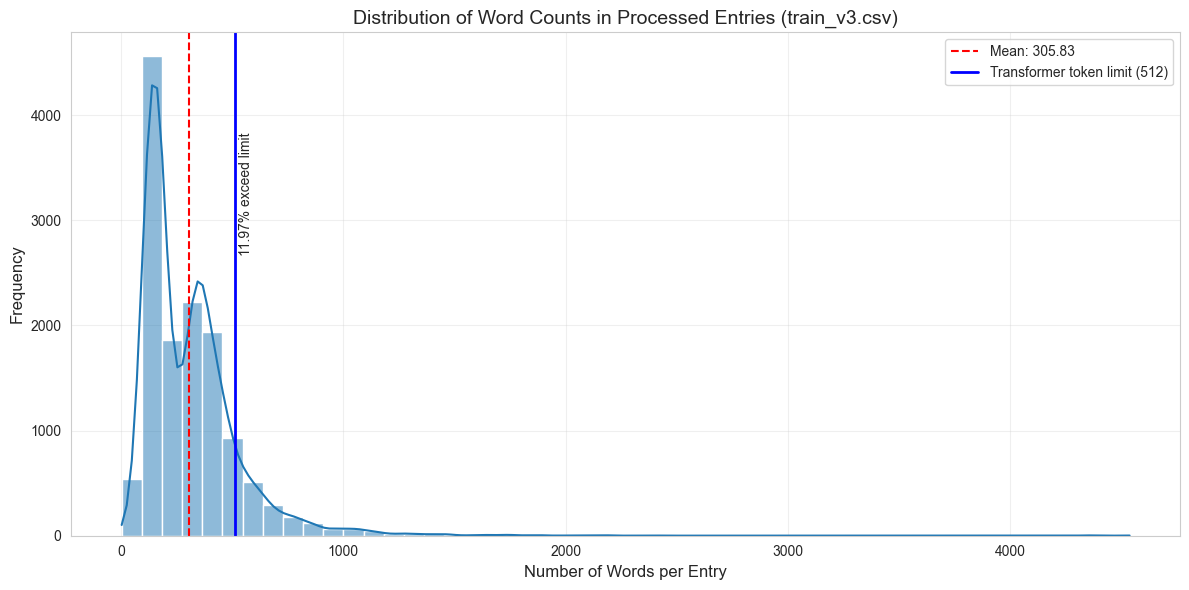

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the final processed dataset
final_df = pd.read_csv('../T_Q1/train_v3.csv')

# Calculate word counts for each entry
word_counts = final_df['Text'].apply(lambda x: len(str(x).split()))

# Basic statistics
print(f"Word count statistics:")
print(f"  Minimum: {word_counts.min()}")
print(f"  Maximum: {word_counts.max()}")
print(f"  Mean: {word_counts.mean():.2f}")
print(f"  Median: {word_counts.median()}")
print(f"  Standard deviation: {word_counts.std():.2f}")

# Set the style for the plot
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Plot histogram
sns.histplot(word_counts, bins=50, kde=True)
plt.title('Distribution of Word Counts in Processed Entries (train_v3.csv)', fontsize=14)
plt.xlabel('Number of Words per Entry', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Add vertical line for mean
plt.axvline(word_counts.mean(), color='red', linestyle='--', linewidth=1.5, label=f'Mean: {word_counts.mean():.2f}')

# Add transformer token limit line
plt.axvline(512, color='blue', linestyle='-', linewidth=2, label='Transformer token limit (512)')

# Calculate percentage of entries exceeding the transformer token limit
pct_exceeding = (word_counts > 512).mean() * 100
plt.text(512 + 20, plt.gca().get_ylim()[1] * 0.8, f"{pct_exceeding:.2f}% exceed limit", 
         rotation=90, verticalalignment='top', fontsize=10)

# Add legend
plt.legend()

# Display plot
plt.tight_layout()
plt.show()

---
## Training

Now, the cleaned data stored in `train_v3.csv` is used to fine-tune the model.

### Train/Test split

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

df = pd.read_csv('../T_Q1/train_v3.csv')

classes = sorted(df['Category'].unique())
class2id = {class_:id for id, class_ in enumerate(classes)}
id2class = {id:class_ for class_, id in class2id.items()}
df['labels'] = df['Category'].map(class2id)

# Perform stratified split to maintain class distribution
train_df, test_df = train_test_split(
    df, 
    test_size=0.2,                # 80/20 split
    stratify=df['Category'],      # Stratify by category to maintain class distribution
)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# Convert to Hugging Face datasets format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict with train and test splits
dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

Training set size: 10711
Test set size: 2678


### Tokenization
DistilBERT is used. It is the distilled version of BERT. It is smaller, faster and maintains 95% of the original BERT's performance. 


All text is truncated to length of 256 (around the mean length of each entry).

In [48]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 2678/2678 [00:00<00:00, 7331.32 examples/s]


Loading the model

In [49]:
from transformers import AutoModelForSequenceClassification

# Initialize a BERT model for binary classification
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=43, id2label=id2class, label2id=class2id)

print(model.config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Accountant",
    "1": "Advocate",
    "2": "Agriculture",
    "3": "Apparel",
    "4": "Architecture",
    "5": "Arts",
    "6": "Automobile",
    "7": "Aviation",
    "8": "BPO",
    "9": "Banking",
    "10": "Blockchain",
    "11": "Building and Construction",
    "12": "Business Analyst",
    "13": "Civil Engineer",
    "14": "Consultant",
    "15": "Data Science",
    "16": "Database",
    "17": "Designing",
    "18": "DevOps",
    "19": "Digital Media",
    "20": "DotNet Developer",
    "21": "ETL Developer",
    "22": "Education",
    "23": "Electrical Engineering",
    "24": "Finance",
    "25": "Food and Beverages",
    "26": "Health and Fitness",
    "27": "Human Resources",
    "28": "Information Technology",
    "29": "Java Developer",
    "30": "Management",
    "31": "Mec

### Training

Let us define the training arguments. These have been chosen carefully after multiple training runs.

The learning rate is set to 5e-5, which is in the range of 2e-5 and 5e-5 used by the BERT authors in the original paper for fine-tuning. It gave the best results.

The batch size is set to 32, since the max token length is 256. Anything larger doesn't fit in my device's GPU memory.

Usually, 5 epochs is the suggested max epochs to use for fine-tuning text-classification models (check references for more info). I have kept it at 8, since larger epochs would show overfitting, but since my strategy is to load `best_model_at_end`, it doesn't matter.

If the current batch size doesn't fit in GPU memory, divide it by 2, and multiply the gradient accumulation step by 2. This way, your GPU doesn't crash at the cost of longer training time.

For CUDA devices, fp16 can be true. It uses mixed precision numbers to speed up training. 

In [50]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",           # Directory for saving model checkpoints
    eval_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",    # Save model at the end of each epoch
    learning_rate=5e-5,              # Start with a small learning rate
    per_device_train_batch_size=16,  # Batch size per GPU
    per_device_eval_batch_size=8,
    num_train_epochs=8,              # Number of epochs
    save_total_limit=2,              # Limit checkpoints to save space
    load_best_model_at_end=True,     # Automatically load the best checkpoint
    logging_dir="./logs",            # Directory for logs
    logging_steps=100,
    optim="adamw_torch_fused",
    fp16=False,
    use_mps_device=True,
    gradient_accumulation_steps=4,
    dataloader_pin_memory=False,
)

print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=False,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=Fals

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/training_args.py:2214: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


F1 score is used as the evaluation metric. Weighted F1 score takes in consideration the class imbalance, hence giving a truer picture of the model's performance.

In [51]:
from transformers import Trainer
from evaluate import load

# Load a metric (F1-score in this case)
metric = load("f1")

# Define a custom compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

Data Collator efficiently collects the data into batches. 

For example say, lengths of 6 sample embeddings are 2, 3, 5, 8, 15 and 17. My `batch_size` is 2. I set my max token length to 20. Then instead of padding all samples to 20, it takes `batch_size` samples and pads them to the longest embedding in the batch. So, 2, 3 are padded to 3; 5, 8 are padded to 8; and 15, 17 are padded to 17. This saves a lot of memory and time.


In [52]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Finally, we start the training/fine-tuning process. 

In [53]:
import torch

torch.mps.empty_cache()

trainer = Trainer(
    model=model,                        # Pre-trained BERT model
    args=training_args,                 # Training arguments
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,        # Efficient batching
    compute_metrics=compute_metrics     # Custom metric
)


# Start training
trainer.train()

/var/folders/sl/jk76y0gs0yzbmy64jctwg9xm0000gn/T/ipykernel_71303/1189745718.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,2.898200,1.194606,0.721266
2,0.930900,0.822901,0.791531
3,0.616500,0.736426,0.810479
4,0.483500,0.730745,0.813741
5,0.361000,0.727746,0.824495
6,0.277900,0.719630,0.830980
7,0.224400,0.729604,0.828412
8,0.189200,0.728081,0.835148


TrainOutput(global_step=1344, training_loss=0.6822998041198367, metrics={'train_runtime': 2248.7449, 'train_samples_per_second': 38.105, 'train_steps_per_second': 0.598, 'total_flos': 5679582973095936.0, 'train_loss': 0.6822998041198367, 'epoch': 8.0})

## Validation Metrics

Following codes show class-wise F1 scores, precision and recall, as well as the overall metrics. They also show the confusion matrix and worst performing classes for targeted analysis.

/var/folders/sl/jk76y0gs0yzbmy64jctwg9xm0000gn/T/ipykernel_71303/413247211.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_best = Trainer(


=== Model Evaluation Metrics ===
Accuracy: 0.8372
Weighted F1-Score: 0.8351
Macro F1-Score: 0.8312
Micro F1-Score: 0.8372
Precision (weighted): 0.8368
Recall (weighted): 0.8372

=== Detailed Classification Report ===
                           precision    recall  f1-score   support

               Accountant     0.9437    0.9571    0.9504        70
                 Advocate     0.9062    1.0000    0.9508        58
              Agriculture     0.8529    0.9831    0.9134        59
                  Apparel     0.8382    0.8906    0.8636        64
             Architecture     0.8594    0.7971    0.8271        69
                     Arts     0.9104    0.9242    0.9173        66
               Automobile     0.6545    0.5714    0.6102        63
                 Aviation     0.9189    1.0000    0.9577        68
                      BPO     0.8000    0.6000    0.6857        40
                  Banking     0.9831    0.9206    0.9508        63
               Blockchain     1.0000    0.888

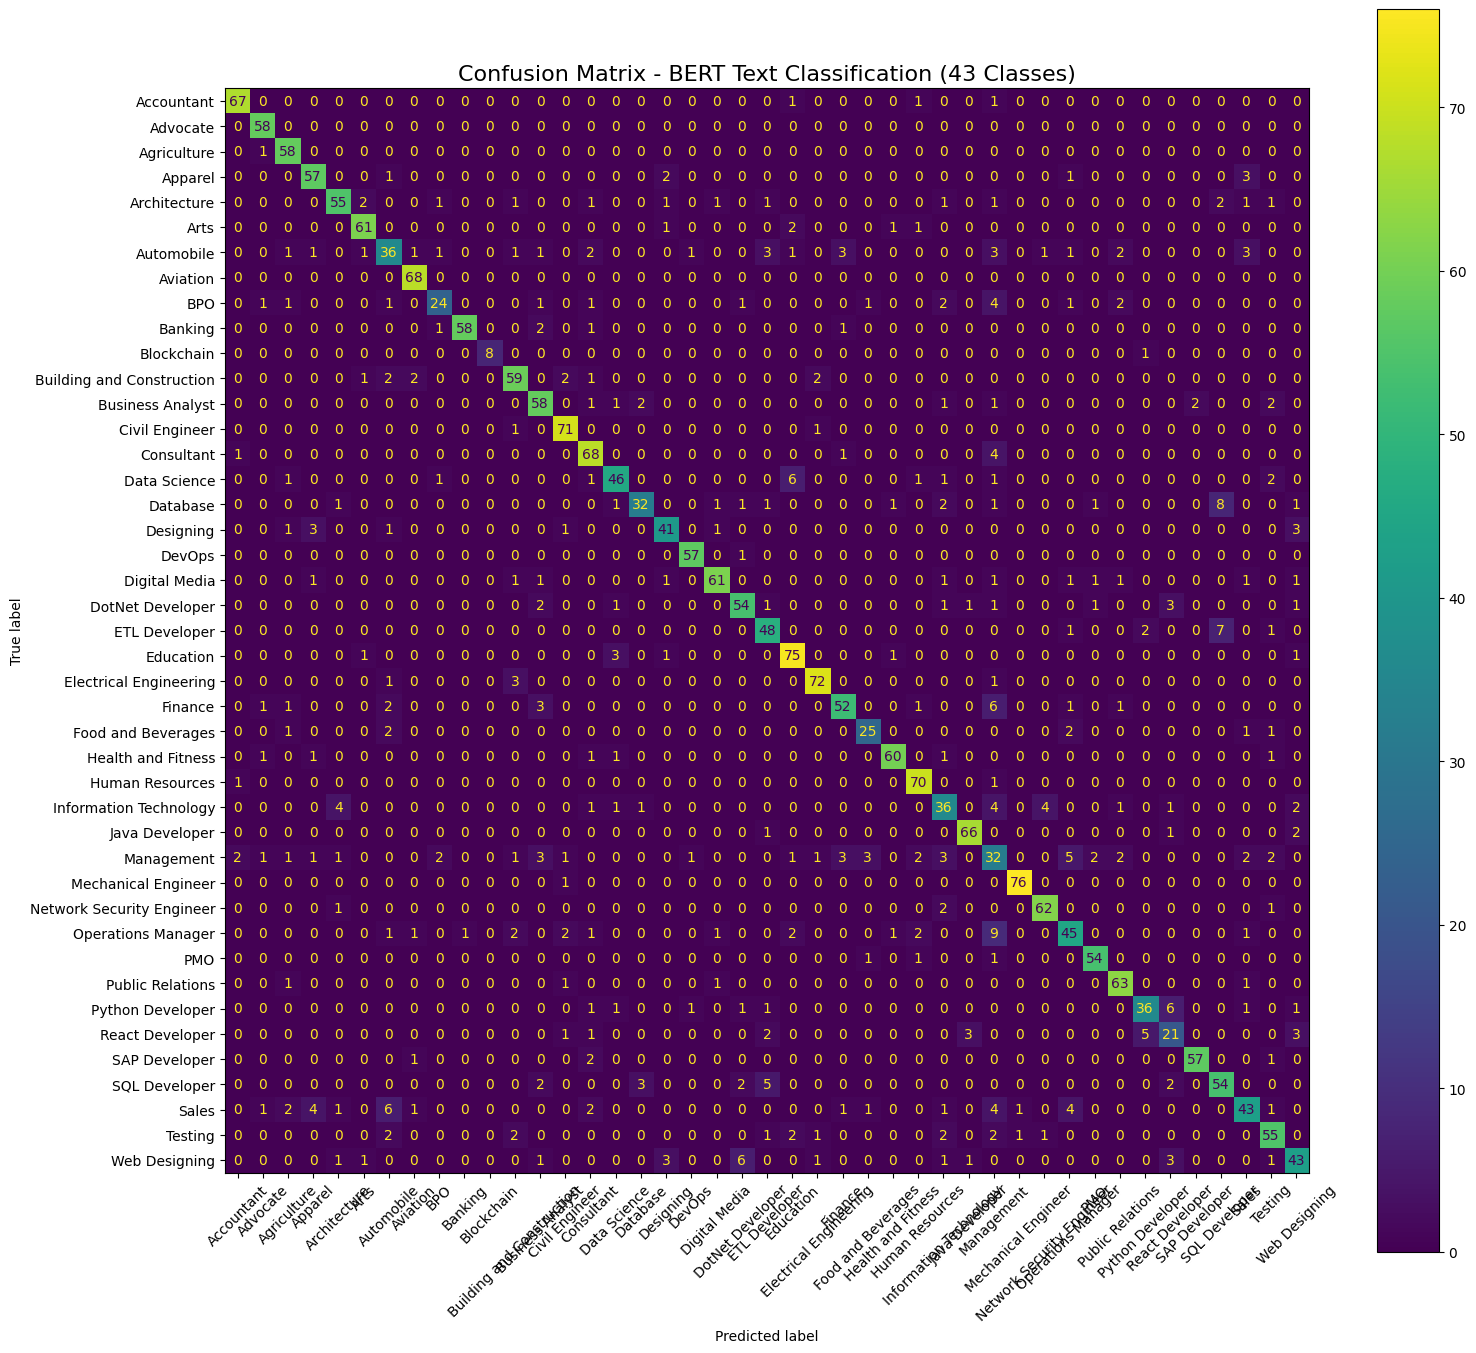

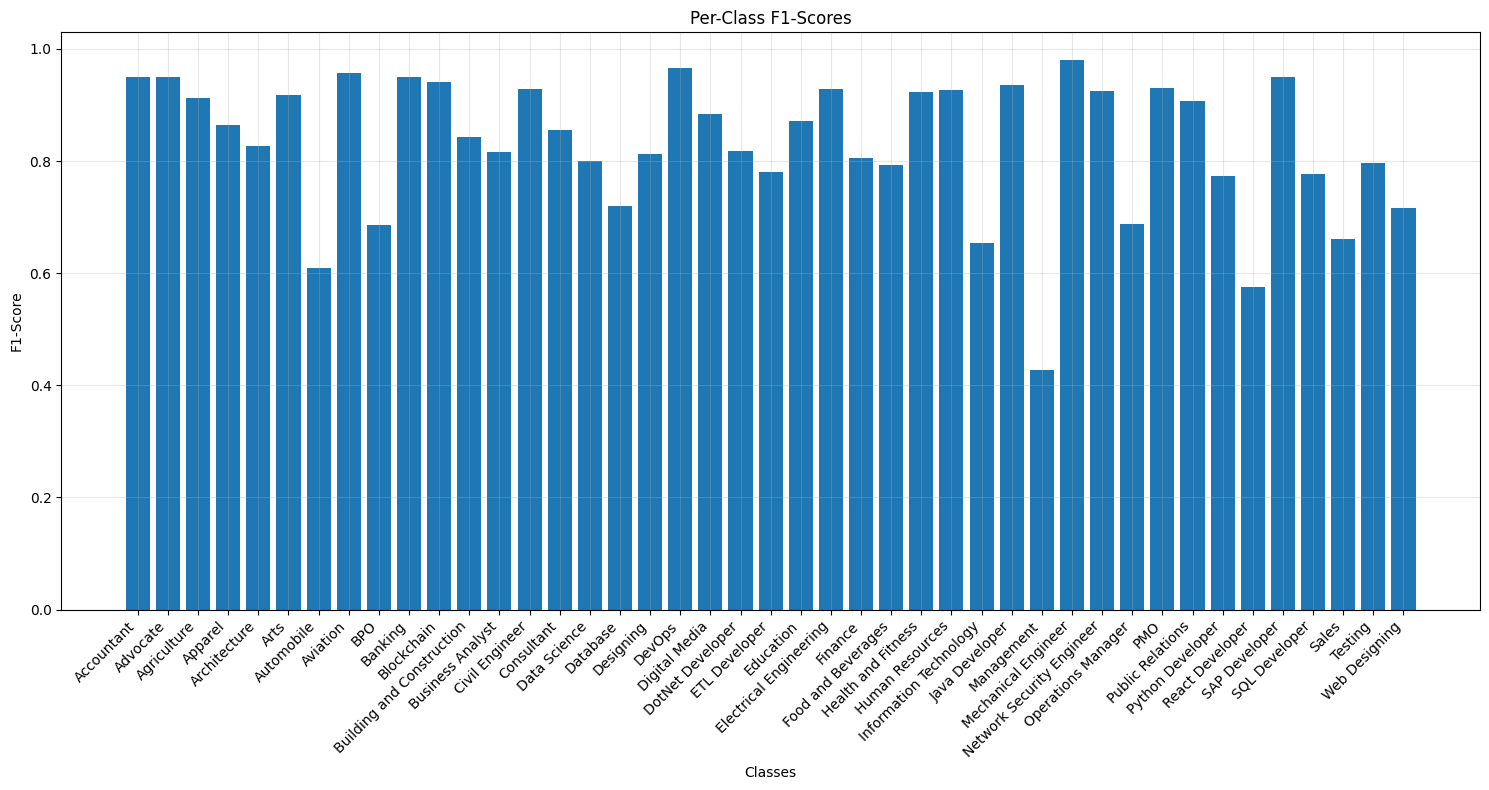


Best performing classes (Top 5 F1-scores):
  Mechanical Engineer: 0.9806
  DevOps: 0.9661
  Aviation: 0.9577
  Advocate: 0.9508
  Banking: 0.9508

Worst performing classes (Bottom 5 F1-scores):
  Management: 0.4267
  React Developer: 0.5753
  Automobile: 0.6102
  Information Technology: 0.6545
  Sales: 0.6615


In [54]:
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Load the best model from checkpoint
best_model_path = "results/checkpoint-1344"
model_best = AutoModelForSequenceClassification.from_pretrained(best_model_path)

# Create a new trainer with the best model for evaluation
trainer_best = Trainer(
    model=model_best,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Generate predictions on test set
predictions = trainer_best.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)
true_labels = tokenized_datasets["test"]["labels"]

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, support = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
macro_f1 = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')[2]
micro_f1 = precision_recall_fscore_support(true_labels, predicted_labels, average='micro')[2]

print("=== Model Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Micro F1-Score: {micro_f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")

# Detailed classification report
print("\n=== Detailed Classification Report ===")
print(classification_report(true_labels, predicted_labels, target_names=classes, digits=4))

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
fig, ax = plt.subplots(figsize=(16, 14))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, xticks_rotation=45, values_format='d')
plt.title('Confusion Matrix - BERT Text Classification (43 Classes)', fontsize=16)
plt.tight_layout()
plt.show()

# Per-class performance analysis
per_class_metrics = classification_report(true_labels, predicted_labels, target_names=classes, output_dict=True)
class_f1_scores = [per_class_metrics[class_name]['f1-score'] for class_name in classes]

# Plot per-class F1 scores
plt.figure(figsize=(15, 8))
plt.bar(range(len(classes)), class_f1_scores)
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('Per-Class F1-Scores')
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest performing classes (Top 5 F1-scores):")
best_classes = sorted(zip(classes, class_f1_scores), key=lambda x: x[1], reverse=True)[:5]
for class_name, f1_score in best_classes:
    print(f"  {class_name}: {f1_score:.4f}")

print(f"\nWorst performing classes (Bottom 5 F1-scores):")
worst_classes = sorted(zip(classes, class_f1_scores), key=lambda x: x[1])[:5]
for class_name, f1_score in worst_classes:
    print(f"  {class_name}: {f1_score:.4f}")


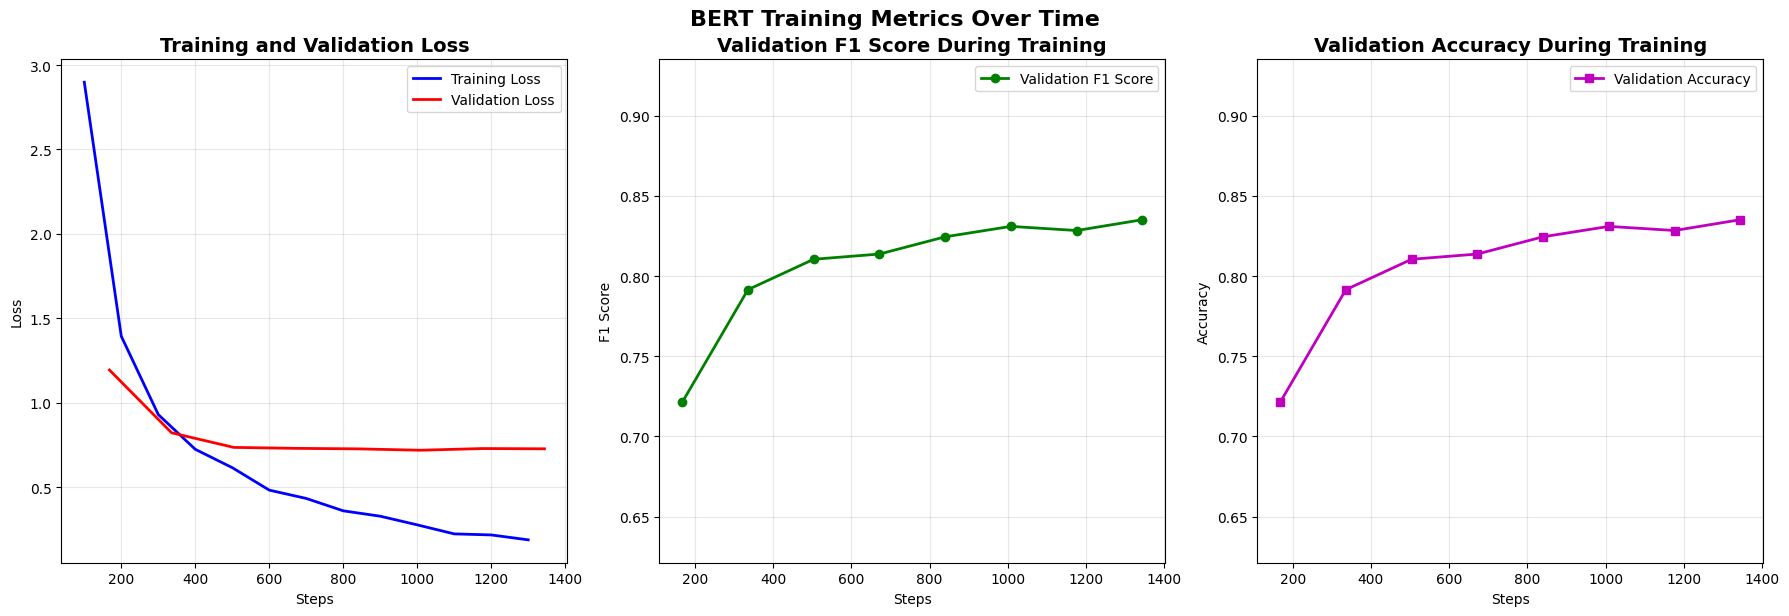

=== Training Summary ===
Total training steps: 1300
Final training loss: 0.1892
Final validation loss: 0.7281
Final validation F1: 0.8351
Best validation F1: 0.8351
Best validation loss: 0.7196

=== Epoch-wise Performance ===
Epoch 1: Step 168, F1: 0.7213, Loss: 1.1946
Epoch 2: Step 336, F1: 0.7915, Loss: 0.8229
Epoch 3: Step 504, F1: 0.8105, Loss: 0.7364
Epoch 4: Step 672, F1: 0.8137, Loss: 0.7307
Epoch 5: Step 840, F1: 0.8245, Loss: 0.7277
Epoch 6: Step 1008, F1: 0.8310, Loss: 0.7196
Epoch 7: Step 1176, F1: 0.8284, Loss: 0.7296
Epoch 8: Step 1344, F1: 0.8351, Loss: 0.7281


In [55]:
import json
import os
import matplotlib.pyplot as plt

# Load training logs from the checkpoint file
checkpoint_path = "results/checkpoint-1344"

# Load logs from checkpoint file
if os.path.exists(f"{checkpoint_path}/trainer_state.json"):
    with open(f"{checkpoint_path}/trainer_state.json", 'r') as f:
        trainer_state = json.load(f)
        log_history = trainer_state['log_history']
else:
    # Use trainer_best's log_history as fallback
    log_history = trainer_best.state.log_history

# Extract training and validation metrics
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_f1 = []
eval_accuracy = []

for log in log_history:
    if 'loss' in log and 'step' in log:  # Training logs
        train_steps.append(log['step'])
        train_loss.append(log['loss'])
    elif 'eval_loss' in log and 'step' in log:  # Evaluation logs
        eval_steps.append(log['step'])
        eval_loss.append(log['eval_loss'])
        if 'eval_f1' in log:
            eval_f1.append(log['eval_f1'])
            
        # Calculate accuracy from f1 if accuracy not directly available
        if 'eval_accuracy' in log:
            eval_accuracy.append(log['eval_accuracy'])
        else:
            eval_accuracy.append(log['eval_f1'])  # Using F1 as proxy for accuracy

# Create subplots with 3 graphs (removing the F1 vs Accuracy graph)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Training and Validation Loss
ax1.plot(train_steps, train_loss, 'b-', label='Training Loss', linewidth=2)
ax1.plot(eval_steps, eval_loss, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation F1 Score
ax2.plot(eval_steps, eval_f1, 'g-', label='Validation F1 Score', linewidth=2, marker='o')
ax2.set_title('Validation F1 Score During Training', fontsize=14, fontweight='bold')
ax2.set_xlabel('Steps')
ax2.set_ylabel('F1 Score')
ax2.legend()
ax2.grid(True, alpha=0.3)
if len(eval_f1) > 0 and min(eval_f1) > 0:
    ax2.set_ylim([max(0.5, min(eval_f1) - 0.1), min(1.0, max(eval_f1) + 0.1)])

# Validation Accuracy
ax3.plot(eval_steps, eval_accuracy, 'm-', label='Validation Accuracy', linewidth=2, marker='s')
ax3.set_title('Validation Accuracy During Training', fontsize=14, fontweight='bold')
ax3.set_xlabel('Steps')
ax3.set_ylabel('Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)
if len(eval_accuracy) > 0 and min(eval_accuracy) > 0:
    ax3.set_ylim([max(0.5, min(eval_accuracy) - 0.1), min(1.0, max(eval_accuracy) + 0.1)])

plt.tight_layout()
plt.suptitle('BERT Training Metrics Over Time', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print training summary
print("=== Training Summary ===")
print(f"Total training steps: {max(train_steps) if train_steps else 'N/A'}")
print(f"Final training loss: {train_loss[-1]:.4f}" if train_loss else "N/A")
print(f"Final validation loss: {eval_loss[-1]:.4f}" if eval_loss else "N/A")
print(f"Final validation F1: {eval_f1[-1]:.4f}" if eval_f1 else "N/A")
print(f"Best validation F1: {max(eval_f1):.4f}" if eval_f1 else "N/A")
print(f"Best validation loss: {min(eval_loss):.4f}" if eval_loss else "N/A")

# Show epoch-wise performance
if eval_steps and eval_f1:
    print("\n=== Epoch-wise Performance ===")
    epochs = len(eval_steps)
    for i, (step, f1, loss) in enumerate(zip(eval_steps, eval_f1, eval_loss)):
        print(f"Epoch {i+1}: Step {step}, F1: {f1:.4f}, Loss: {loss:.4f}")

## Analysis of Results
The initial data preprocssing step increased f1 score by almost 5%. It also reduced the average word count per entry, hence reducing training time by 50%. 

5 epochs were enough to reach the best metrics. Distilled model use improved training time, while providing similar performance. 

 Management, React Developer, Automobile, Information Technology and Sales were the worst performing classes. The likely reasons for this are that Management, IT and Sales are very broad, categories whose resumes overlap considerably with other fields. (Even if you want to be a software developer, you do include the fact that you have leadership skills, which is actually the domain of management). Also, Automobile had only about 120 entries, which might not have been enough to identify relevant features.

 There were certain places where the model struggled considerably. Such as confusing between Python and React developer, Management and Operations Manager, Automobile and Sales etc. 

 A good way to improve the model would be to increase entries in the classes. Second, I had to limit the max token length to 256, to finish training in a reasonable time. If this was kept at 512, the model would have greater chance of inferring a pattern. Using the original BERT model, or newer, more powerful ones Like ModernBERT, will definitely give at least a 5% improvement in performance (inferred by comparing their GLUE benchmark scores). 
 
 Lastly, the data was ill-prepared. Many entries had grammatical errors. Some shortforms were used which were lost in casing. Improving upon these parameters might help too. There were also many features that I didn't try, such as weight decay, learning rate schedulers etc. These hyperparameters, coupled with software like Optuna can help extract the best performance from the model.